In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import faceted as faceted
import xarray as xr
import numpy as np
import scipy
from scipy import integrate
import dask.bag as db
from dask.distributed import Client, progress
import dask_jobqueue

sns.set_style('ticks')

plt.rcParams.update({
    "text.usetex": True,
    "font.size": 9,
    "text.latex.preamble": "\n".join([r'\usepackage{amsmath}'])
}) 

In [3]:
ds = xr.open_dataset("../data/reanalysis/ERA5_land_zonal_avg_troposphere.nc")
ds = ds.rename({'isobaricInhPa': 'p'}) #convenient name
g = 9.81
ds['z'] = ds.z/g #convert z, which is actually geopotential, to height
ds = ds.where(ds.p > 10, drop=True).sel(latitude=slice(90,-90)) #drop upper stratosphere
ds['latitude'] = np.sin(np.deg2rad(ds.latitude)) #make latitude sin(latitude)

R = 287.04
cp = 1000
H = R*288/g
ds["Z"] = -H*np.log(ds.p/1e3)
ds = ds.swap_dims({"p":"Z"})

In [4]:
#find the To to ascend to a single height z for a given latitude
def find_dry_To_single_z(z, z_p, s_e_p, epsilon=.2/1000):
    z0 = 1000 #m
    def se_interp(z): return scipy.interp(z, z_p, s_e_p)
    def integrand(z): return np.exp(epsilon*z)*se_interp(z)
    def integral(z): return integrate.quad(integrand, z0, z)[0]
    def To(z): return ((se_interp(z) - epsilon*np.exp(-epsilon*z)*integral(z)
                       )*np.exp(epsilon*(z-z0)) - se_interp(z0))/cp 
    return To(z)

# distribute the computation across latitude in xarray
def find_dry_To_single_z_xr(i, ds=ds, epsilon=.2/1000):
    data_single_Z = xr.apply_ufunc(find_dry_To_single_z, ds.z.sel(Z=ds.Z[i]),
                         ds.z, s_e, input_core_dims=[[], ["Z"], ["Z"]],
                         exclude_dims=set(("Z",)), vectorize=True, 
                         kwargs={"epsilon": epsilon})
    return data_single_Z

#distribute the computation in height with dask
def find_dry_To(ds, epsilon):
    bag = db.from_sequence(np.arange(len(ds.Z))).map(
        find_dry_To_single_z_xr, epsilon=epsilon, ds=ds)
    result = bag.compute()
    data = xr.concat(result, dim='Z')
    return data 

In [4]:
#computation requires limited memory but is compute intensive and is accelerated by using a dask cluster
cluster = dask_jobqueue.SLURMCluster()
client = Client(cluster)
cluster.scale_up(1)

In [5]:
file = "../data/reanalysis/ERA5_land_zonal_avg_tropopauses.nc"
ds_trop =  xr.open_dataset(file)
trop_wmo_p = ds_trop.wmo_1st_p
trop_wmo_p['lat'] = np.sin(np.deg2rad(trop_wmo_p.lat))
Z_wmo = -H*np.log(trop_wmo_p/1e3)

trop_dyn_p = ds_trop.dyn_p
trop_dyn_p['lat'] = np.sin(np.deg2rad(trop_dyn_p.lat))
Z_dyn = -H*np.log(trop_dyn_p/1e3)

trop_clp_p = ds_trop.clp_p
trop_clp_p['lat'] = np.sin(np.deg2rad(trop_clp_p.lat))
Z_clp = -H*np.log(trop_clp_p/1e3)

In [6]:
s_e = cp*ds.t + g*ds.z 
ds_bl = ds.interp(Z=1000, method='nearest')
s_e0 = cp*ds_bl.t + g*ds_bl.z

In [1]:
To_R_1km = find_dry_To(ds, .2/1000)

In [2]:
To_R_10km = find_dry_To(ds, .2/10000)

/tmp/ipykernel_155087/4017932432.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[0].set_yticklabels([0, 5, 10, 15, 20, 25, 30], fontsize=14)


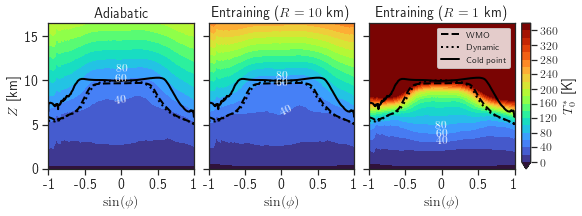

In [45]:
fig, axis, caxis = faceted.faceted(1,3, sharex=True, width=8.0, aspect=1.0,
                                   internal_pad=.2, cbar_mode='edge', 
                                   cbar_pad=.1,
                                   left_pad=.6, bottom_pad=.6, right_pad=.7)
vmax = 400
vmin = 0
levels = np.arange(vmin,vmax,20)

cmap='turbo'

im = ((s_e - s_e0)/cp).plot.contourf( ax=axis[0], add_colorbar=False, #cbar_ax=caxis[0],
#                                 cbar_kwargs={'label':"$T_0^{*}$ [K]",
#                                             'ticks': levels},
                                cmap=cmap, vmax=vmax, vmin=vmin, levels=levels)

cb = plt.colorbar(im, cax=caxis[0], orientation="vertical")
cb.set_label(label="$T_0^{*}$ [K]", size=14)
# cb.ax.tick_params(labelsize='large')


To_R_10km.plot.contourf(ax=axis[1], cmap=cmap, vmax=vmax, vmin=vmin, levels=levels, add_colorbar=False)
To_R_1km.plot.contourf(ax=axis[2], cmap=cmap, vmax=vmax, vmin=vmin, levels=levels, add_colorbar=False)

manual=([0, 15e3], [0, 19e3], [0,25e3])
CS = ((s_e - s_e0)/cp).plot.contour(ax=axis[0], colors="k",
                               levels=[40, 60, 80], add_colorbar=False, linewidths=0.0)
axis[0].clabel(CS, CS.levels, inline=False, colors="white", fontsize=12, manual=manual)

manual=([0, 15e3], [0, 18e3], [0,25e3])


CS = To_R_10km.plot.contour(ax=axis[1], colors="k",
                               levels=[40, 60, 80], add_colorbar=False, linewidths=0.0)
axis[1].clabel(CS, CS.levels, inline=False, colors="white", fontsize=12, manual=manual)


manual=([0, 7e3], [0, 8e3], [0, 9e3])

CS = To_R_1km.plot.contour(ax=axis[2], colors="k",
                               levels=[40, 60, 80], add_colorbar=False, linewidths=0.0)
axis[2].clabel(CS, CS.levels, inline=False, colors="white", fontsize=12, manual=manual)

for t in caxis[0].get_yticklabels():
     t.set_fontsize(12)
        
for ax in axis:
    Z_wmo.plot(color='black', ax=ax, linewidth=2.0, linestyle='dashed', label='WMO')
    Z_dyn.plot(color='black', ax=ax, linestyle='dotted', linewidth=2.0, label='Dynamic')
    Z_clp.plot(color='black', ax=ax, linestyle='solid', linewidth=2.0, label='Cold point')
    ax.set_xlabel("$\\sin(\phi)$", fontsize=14)
    ax.set_ylabel(" ")
    ax.set_xticks([-1, -.5, 0, .5, 1])
    ax.set_xticklabels([-1, -.5, 0, .5, 1], fontsize=14)


axis[0].set_ylabel('$Z$ [km]', fontsize=14)
axis[0].set_yticklabels([0, 5, 10, 15, 20, 25, 30], fontsize=14)
leg = axis[2].legend(fontsize="medium")

axis[0].set_title("Adiabatic", fontsize=14)
axis[1].set_title("Entraining ($R = 10$ km)", fontsize=14)
axis[2].set_title("Entraining ($R = 1$ km)", fontsize=14)